In [1]:
!pip uninstall imgaug --yes
!pip install imgaug==0.2.5
!pip install nfts
!pip install stumpy
!pip install statsmodels --upgrade
!pip install dtw-python
!pip install transformers
!pip install backports-datetime-fromisoformat

Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 562 kB 5.1 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.5-py3-none-any.whl size=561438 sha256=d1b4cc741fe83585a4fae5b8c0444787bac14ce152ded89a14f7fdc06962f972
  Stored in directory: /root/.cache/pip/wheels/60/dd/38/d1dc2cad2b6a66dc0249261004990bccb0f27985c74ba26e49
Successfully built imgaug
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 500 kB 6.6 MB/s 
     |████████████████████████████████| 3.0 MB 48.5 MB/s 
     |████████████████████████████████| 209 kB 69.7 MB/s 
     |████████████████████████████████| 78 kB 6.5 MB/s 
     |████████████████████████████████| 103 kB 42.3 MB/s 
     |████████████████████████████████| 101 kB 11.6 MB/s 
     |█

In [1]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
from datetime import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time
import matplotlib.pyplot as plt
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nfts.dataset
import stumpy

import torch
from tqdm import tqdm

%matplotlib inline
sns.set(color_codes=True)

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

INFO:numba.cuda.cudadrv.driver:init
ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [2]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/NFT/data/'

Mounted at /content/drive


# Read Tweets and trades data

### Tweets

In [3]:
df_april = pd.read_csv(DATA_PATH + 'april.csv')
df_may = pd.read_csv(DATA_PATH + 'may.csv')
df_june = pd.read_csv(DATA_PATH + 'june.csv')
df_july = pd.read_csv(DATA_PATH + 'july.csv')
df_august = pd.read_csv(DATA_PATH + 'august.csv')
df_sep = pd.read_csv(DATA_PATH + 'september.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,2,4,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
frame = [df_april, df_may, df_june, df_july, df_august, df_sep]
df = pd.concat(frame)
df = df.drop_duplicates()

In [ ]:
#df['created_at'] = df['created_at'].apply(lambda x: str(x)[:13])

In [5]:
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True) 

In [6]:
bins = sorted(df['created_at'].dt.date.unique())
bins = [element for element in bins if type(element) == type(bins[0])]
bins = sorted(bins)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Comparison of NaT with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.
  """Entry point for launching an IPython kernel.


### Trades

In [7]:
home_dir = DATA_PATH
DATASET_PATH = os.path.join(home_dir , 'nfts.sqlite')
assert os.path.exists(DATASET_PATH), "Did not find file 'nfts.sqlite' at the given DATASET_PATH."
dataset = nfts.dataset.FromSQLite(DATASET_PATH)

transfers = dataset.load_dataframe('transfers')
transfers['datetime'] = pd.to_datetime(transfers['timestamp'], unit='s')
bins = sorted(transfers['datetime'].dt.date.unique())

# Visualization

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


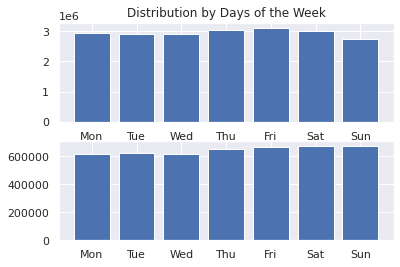

In [27]:
fig, axs = plt.subplots(2)

axs[0].set_title('Distribution by Days of the Week')
axs[0].bar(x = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], height = df.groupby(df["created_at"].dt.weekday).size())
axs[1].bar(x = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], height = transfers.groupby(transfers['datetime'].dt.weekday).size())

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


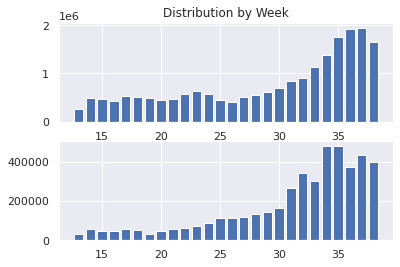

In [28]:
fig, axs = plt.subplots(2)

axs[0].set_title('Distribution by Week')
axs[0].bar(x = range(13,39), height = df.groupby(df["created_at"].dt.week).size())
axs[1].bar(x = range(13,39), height = transfers.groupby(transfers['datetime'].dt.week).size())

plt.show()


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


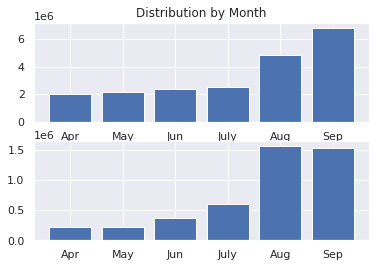

In [29]:
fig, axs = plt.subplots(2)

axs[0].set_title('Distribution by Month')
axs[0].bar(x = ['Apr','May','Jun','July','Aug','Sep'], height = df.groupby(df["created_at"].dt.month).size())
axs[1].bar(x = ['Apr','May','Jun','July','Aug','Sep'], height = transfers.groupby(transfers['datetime'].dt.month).size())

plt.show()

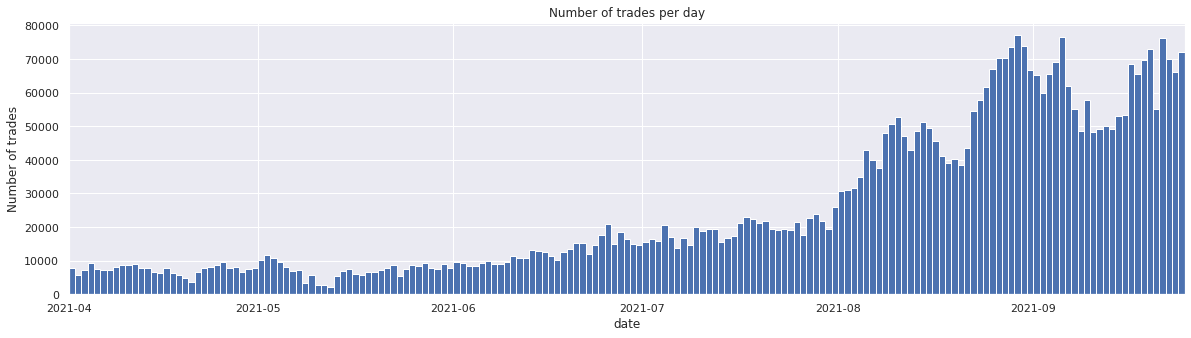

In [30]:
plt.figure(figsize=(20,5))
ax = transfers['datetime'].plot.hist(bins=bins, xlim=(bins[0], bins[-1]), legend=False)
ax.set(xlabel='date', ylabel='Number of trades')
plt.title('Number of trades per day')
plt.show()

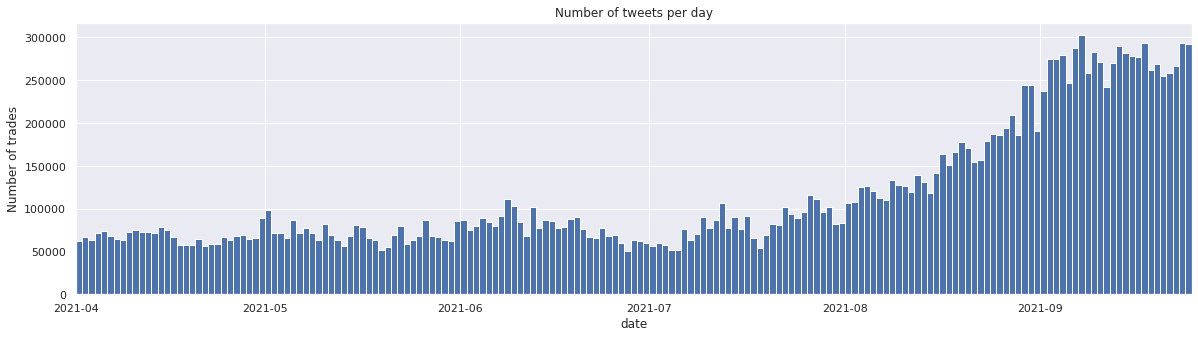

In [31]:
plt.figure(figsize=(20,5))
ax = df['created_at'].plot.hist(bins = bins, xlim=(bins[0], bins[-1]), legend=False)
ax.set(xlabel='date', ylabel='Number of trades')
plt.title('Number of tweets per day')
plt.show()

In [32]:
tweetcount = pd.to_datetime(df['created_at']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count')
tweetcount = tweetcount.sort_values(by=['date'])

tweetcount['3day'] = tweetcount['count'].rolling(3).mean()
tweetcount['2day'] = tweetcount['count'].rolling(2).mean()
tweetcount['7day'] = tweetcount['count'].rolling(7).mean()

In [33]:
temp = pd.to_datetime(df['created_at']).dt.floor('h').value_counts().rename_axis('date').reset_index(name='count')
temp2 = pd.to_datetime(transfers['datetime']).dt.floor('h').value_counts().rename_axis('date').reset_index(name='count')

In [34]:
tradecount = pd.to_datetime(transfers['datetime']).dt.floor('d').value_counts().rename_axis('date').reset_index(name='count')
tradecount = tradecount.sort_values(by=['date'])

tradecount['2day'] = tradecount['count'].rolling(2).mean()
tradecount['3day'] = tradecount['count'].rolling(3).mean()
tradecount['7day'] = tradecount['count'].rolling(7).mean()

In [35]:
import math

list_tweet = tweetcount['count'].tolist()
list_trade = tradecount['count'].tolist()

list_tweet_2mean = tweetcount['2day'].tolist()
list_trade_2mean = tradecount['2day'].tolist()

list_tweet_2mean = [element for element in list_tweet_2mean if math.isnan(element) == False]
list_trade_2mean = [element for element in list_trade_2mean if math.isnan(element) == False]

list_tweet_3mean = tweetcount['3day'].tolist()
list_trade_3mean = tradecount['3day'].tolist()

list_tweet_3mean = [element for element in list_tweet_3mean if math.isnan(element) == False]
list_trade_3mean = [element for element in list_trade_3mean if math.isnan(element) == False]

### Z norm

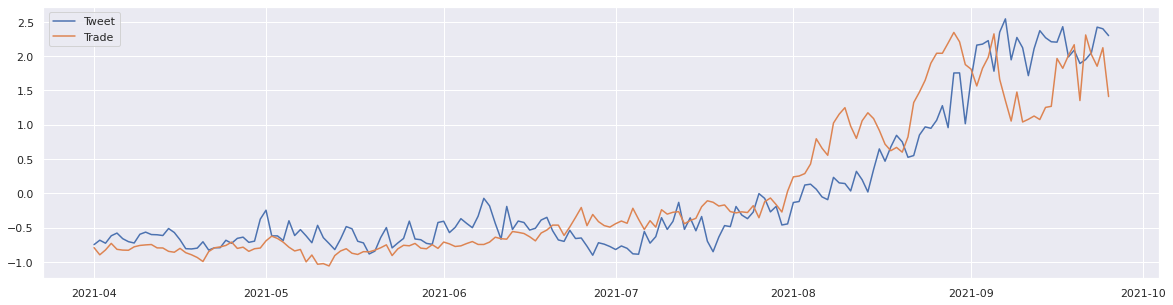

In [36]:
legend = ['Tweet', 'Trade']
plt.figure(figsize=(20,5))
plt.plot(bins, stumpy.core.z_norm(list_tweet))
plt.plot(bins, stumpy.core.z_norm(list_trade))
plt.legend(legend);

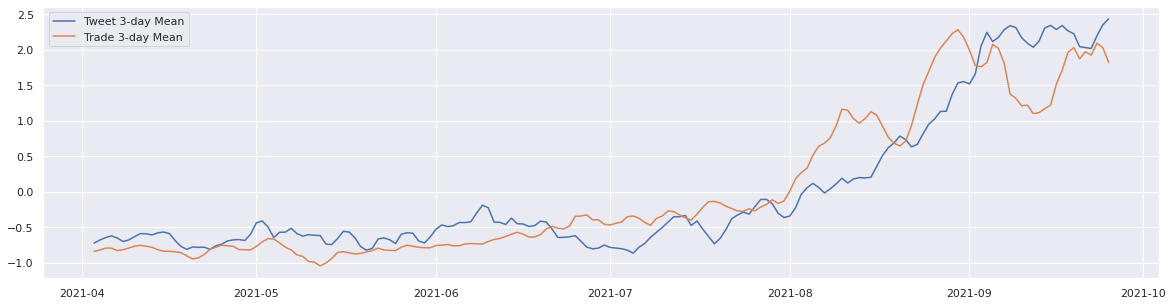

In [37]:
legend = ['Tweet 3-day Mean', 'Trade 3-day Mean']
plt.figure(figsize=(20,5))
plt.plot(bins[2:], stumpy.core.z_norm(list_tweet_3mean))
plt.plot(bins[2:], stumpy.core.z_norm(list_trade_3mean))
plt.legend(legend);

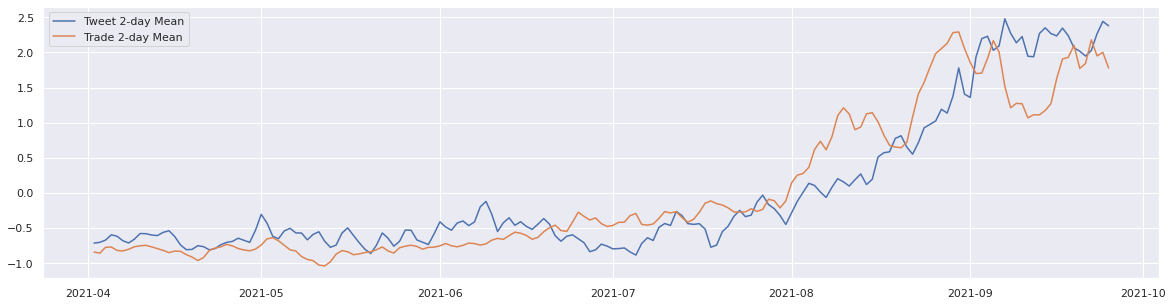

In [38]:
legend = ['Tweet 2-day Mean', 'Trade 2-day Mean']
plt.figure(figsize=(20,5))
plt.plot(bins[1:], stumpy.core.z_norm(list_tweet_2mean))
plt.plot(bins[1:], stumpy.core.z_norm(list_trade_2mean))
plt.legend(legend);

### Max Min norm

In [39]:
import math

list_tweet = tweetcount['count'].tolist()
list_trade = tradecount['count'].tolist()

list_tweet_mean = tweetcount['3day'].tolist()
list_trade_mean = tradecount['3day'].tolist()

list_tweet_mean = [element for element in list_tweet_mean if math.isnan(element) == False]
list_trade_mean = [element for element in list_trade_mean if math.isnan(element) == False]

list_tweet = [(element-np.min(list_tweet))/(np.max(list_tweet)-np.min(list_tweet)) for element in list_tweet]
list_trade = [(element-np.min(list_trade))/(np.max(list_trade)-np.min(list_trade)) for element in list_trade]

list_tweet_mean = [(element-np.nanmin(list_tweet_mean))/(np.nanmax(list_tweet_mean)-np.nanmin(list_tweet_mean)) for element in list_tweet_mean if math.isnan(element) == False]
list_trade_mean = [(element-np.nanmin(list_trade_mean))/(np.nanmax(list_trade_mean)-np.nanmin(list_trade_mean)) for element in list_trade_mean if math.isnan(element) == False]

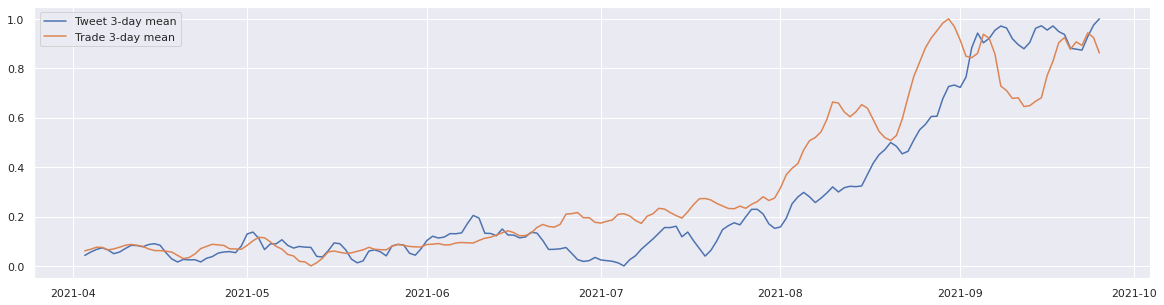

In [40]:
legend = ['Tweet 3-day mean', 'Trade 3-day mean']
plt.figure(figsize=(20,5))
#plt.plot(bins, list1)
#plt.plot(bins, list2)
plt.plot(bins[2:], list_tweet_mean)
plt.plot(bins[2:], list_trade_mean)
plt.legend(legend);

### Déformation temporelle dynamique

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



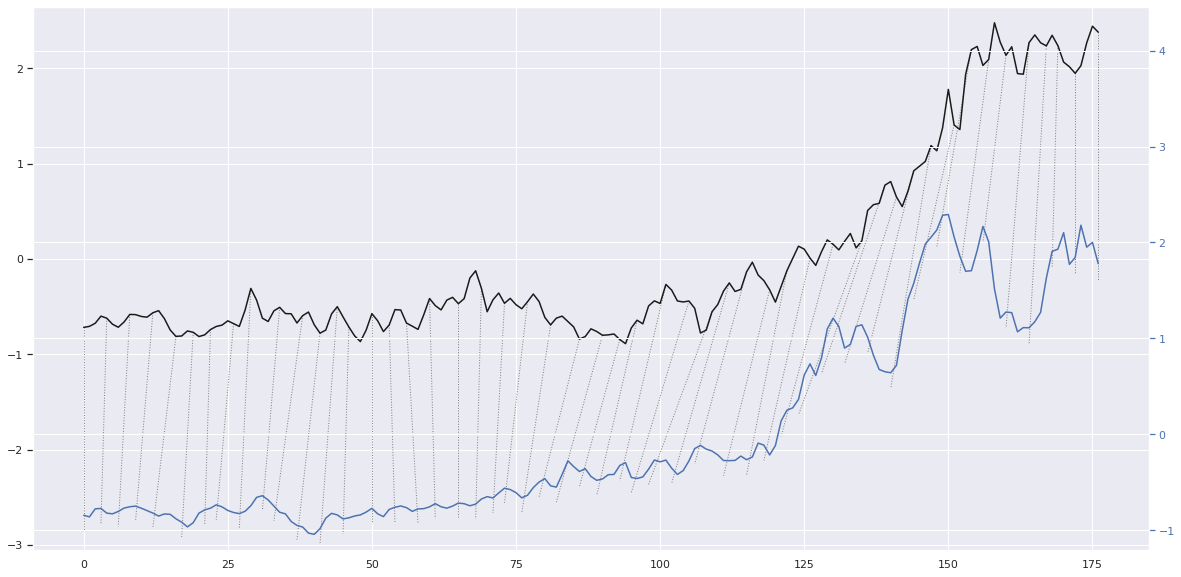

In [42]:
from dtw import *
#alignment = dtw(stumpy.core.z_norm(list_tweet_2mean), stumpy.core.z_norm(list_trade_2mean), keep_internals=True)
#plt.rcParams["figure.figsize"] = (5,5)
## Display the warping curve, i.e. the alignment curve
#alignment.plot(type="threeway");

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
dtw(stumpy.core.z_norm(list_tweet_2mean), stumpy.core.z_norm(list_trade_2mean), keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2);

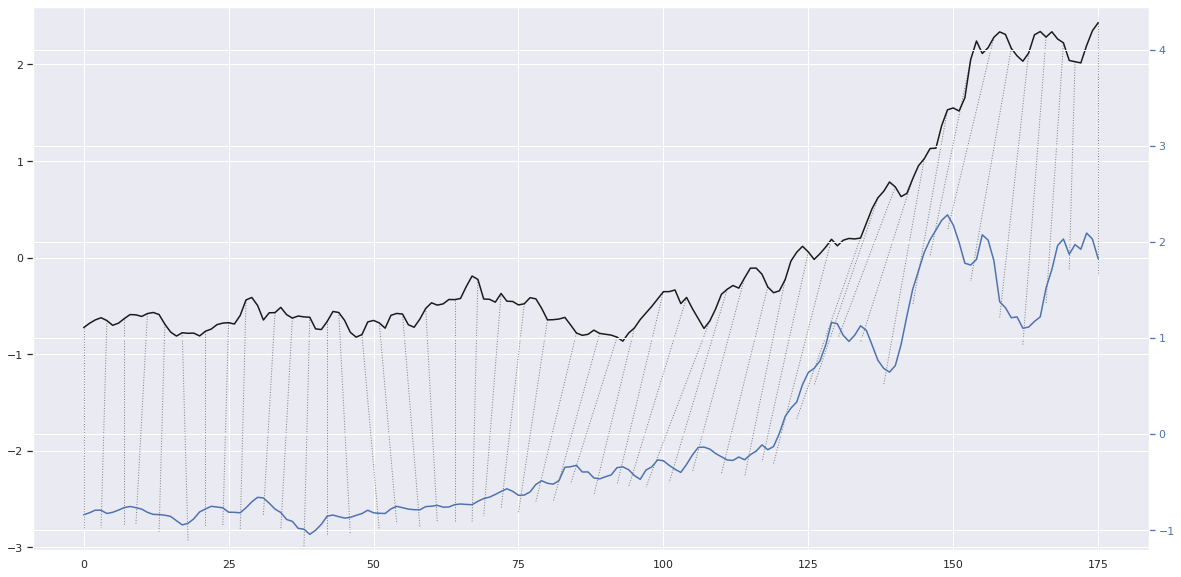

In [44]:
dtw(stumpy.core.z_norm(list_tweet_3mean), stumpy.core.z_norm(list_trade_3mean), keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2);

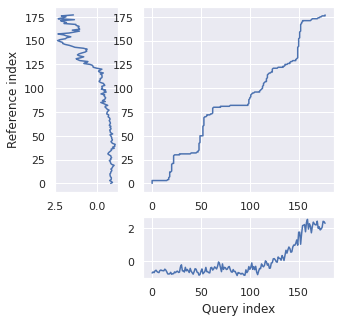

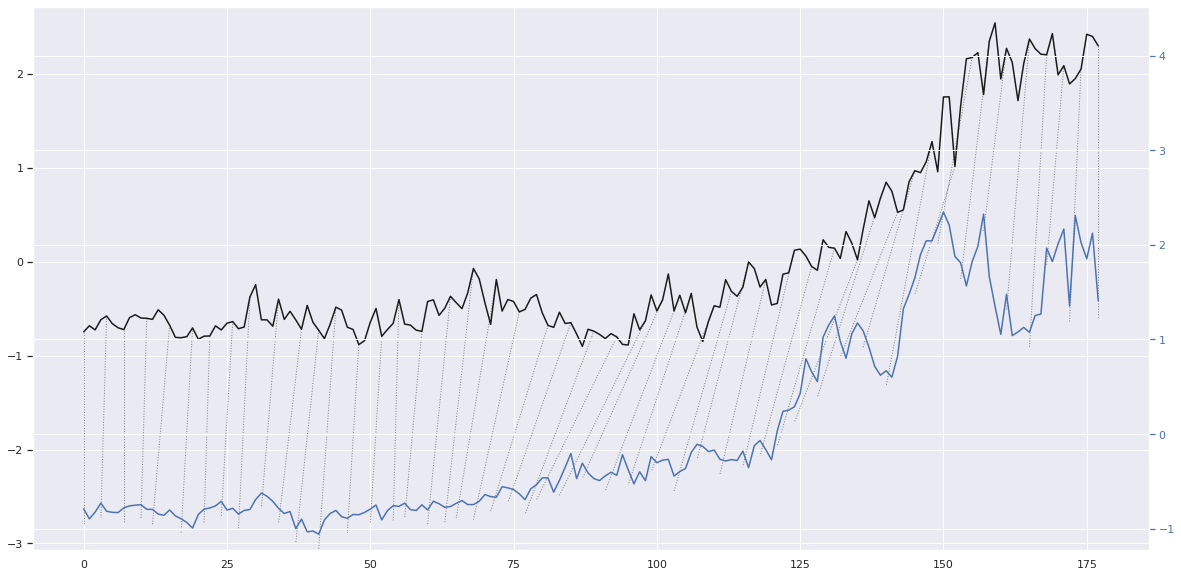

In [49]:
alignment = dtw(stumpy.core.z_norm(list_tweet), stumpy.core.z_norm(list_trade), keep_internals=True)
plt.rcParams["figure.figsize"] = (5,5)
## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway");


plt.rcParams["figure.figsize"] = (20,10)
dtw(stumpy.core.z_norm(list_tweet), stumpy.core.z_norm(list_trade), keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2);

The nearest neighbor to `Q_df` is located at index 0 in `T_df`


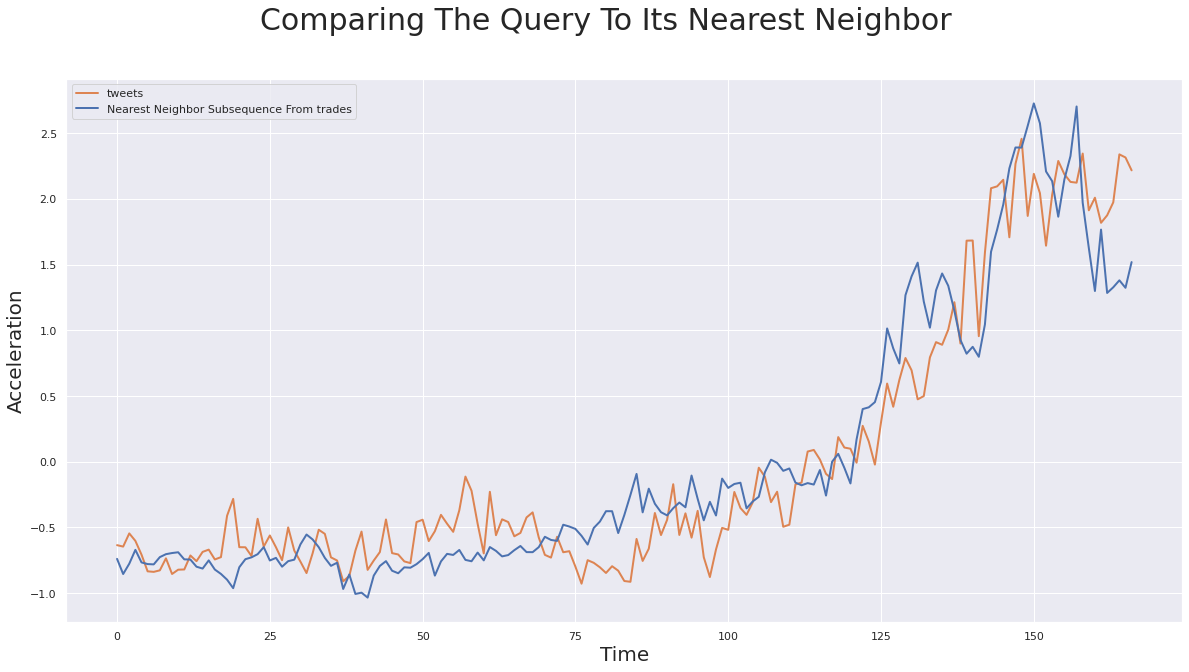

In [ ]:
query = np.array(list_tweet[11:]).astype(np.float64)
compare = np.array(list_trade).astype(np.float64)

distance_profile = stumpy.mass(query, compare)
idx = np.argmin(distance_profile)

#print(distance_profile)
print(f"The nearest neighbor to `Q_df` is located at index {idx} in `T_df`")

# Since MASS computes z-normalized Euclidean distances, we should z-normalize our subsequences before plotting
Q_z_norm = stumpy.core.z_norm(query)
nn_z_norm = stumpy.core.z_norm(list_trade[idx:idx+len(query)])

plt.suptitle('Comparing The Query To Its Nearest Neighbor', fontsize='30')
plt.xlabel('Time', fontsize ='20')
plt.ylabel('Acceleration', fontsize='20')
plt.plot(Q_z_norm, lw=2, color="C1", label="tweets")
plt.plot(nn_z_norm, lw=2, label="Nearest Neighbor Subsequence From trades")
plt.legend()
plt.show()